In [1]:
import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available.")

# Initialize GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf

# Rutas a las carpetas de entrenamiento, prueba y validación para imágenes y máscaras
train_frames_dir = '../../Frames/TRAIN'
train_masks_dir = '../Mask/TRAIN'
test_frames_dir = '../../Frames/TEST'
test_masks_dir = '../Mask/TEST'
val_frames_dir = '../../Frames/VAL'
val_masks_dir = '../Mask/VAL'

# Funciones para cargar y preprocesar imagen y máscara y convertirlo a solo un canal
def load_image(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0
    return image

def load_mask(file_path):
    mask = cv2.imread(file_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask / 255.0
    return mask

train_image_files = [os.path.join(train_frames_dir, filename) for filename in os.listdir(train_frames_dir)]
train_mask_files = [os.path.join(train_masks_dir, filename) for filename in os.listdir(train_masks_dir)]
test_image_files = [os.path.join(test_frames_dir, filename) for filename in os.listdir(test_frames_dir)]
test_mask_files = [os.path.join(test_masks_dir, filename) for filename in os.listdir(test_masks_dir)]
val_image_files = [os.path.join(val_frames_dir, filename) for filename in os.listdir(val_frames_dir)]
val_mask_files = [os.path.join(val_masks_dir, filename) for filename in os.listdir(val_masks_dir)]

train_images = [load_image(file) for file in train_image_files]
train_masks = [load_mask(file) for file in train_mask_files]

test_images = [load_image(file) for file in test_image_files]
test_masks = [load_mask(file) for file in test_mask_files]

val_images = [load_image(file) for file in val_image_files]
val_masks = [load_mask(file) for file in val_mask_files]

train_images = np.array(train_images)
train_masks = np.array(train_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)


In [3]:
# Agremos el path de la carpeta de modelos para poder importar el modelo
import sys
sys.path.append(r'R:\Codes\Reto\Modelos')

In [4]:
# Llamamos a la funcion del modelo U-Net desde un archivo externo
from model1 import unet_model

# Crear el modelo U-Net
model = unet_model(input_shape=(112, 112, 1), n_classes=1, activation='sigmoid')

In [5]:
#Imprimimos el largo de los datos de entrenamiento y prueba
print('Train Images: ', len(train_images))
print('Train Masks: ', len(train_masks))
print('Test Images: ', len(test_images))
print('Test Masks: ', len(test_masks))
print('Val Images: ', len(val_images))
print('Val Masks: ', len(val_masks))

Train Images:  14920
Train Masks:  14920
Test Images:  2552
Test Masks:  2552
Val Images:  2574
Val Masks:  2574


In [6]:
BATCH_SIZE = 16

with tf.device('CPU'):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
    train_dataset = train_dataset.batch(BATCH_SIZE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
    val_dataset = val_dataset.batch(BATCH_SIZE)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
    test_dataset = test_dataset.batch(BATCH_SIZE)

In [7]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=dice_loss, metrics=[dice_coefficient, 'accuracy'])

In [8]:
# Agregamos un callback para detener el entrenamiento si no hay mejora en 10 épocas
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, mode='min', monitor='val_loss')
]

# Entrenamos el modelo
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/100
933/933 [==============================] - 98s 96ms/step - loss: 0.1731 - dice_coefficient: 0.8268 - accuracy: 0.9308 - val_loss: 0.1142 - val_dice_coefficient: 0.8858 - val_accuracy: 0.9503
Epoch 2/100
933/933 [==============================] - 87s 93ms/step - loss: 0.1049 - dice_coefficient: 0.8950 - accuracy: 0.9516 - val_loss: 0.0970 - val_dice_coefficient: 0.9030 - val_accuracy: 0.9526
Epoch 3/100
933/933 [==============================] - 90s 96ms/step - loss: 0.0956 - dice_coefficient: 0.9044 - accuracy: 0.9532 - val_loss: 0.0960 - val_dice_coefficient: 0.9040 - val_accuracy: 0.9532
Epoch 4/100
933/933 [==============================] - 89s 95ms/step - loss: 0.0924 - dice_coefficient: 0.9075 - accuracy: 0.9537 - val_loss: 0.0938 - val_dice_coefficient: 0.9062 - val_accuracy: 0.9534
Epoch 5/100
933/933 [==============================] - 89s 95ms/step - loss: 0.0930 - dice_coefficient: 0.9070 - accuracy: 0.9536 - val_loss: 0.1038 - val_dice_coefficient: 0.8962 - val_ac

In [9]:
evaluation = model.evaluate(test_dataset)

160/160 [==============================] - 4s 25ms/step - loss: 0.9999 - dice_coefficient: 5.0362e-05 - accuracy: 0.8807


160/160 [==============================] - 4s 24ms/step


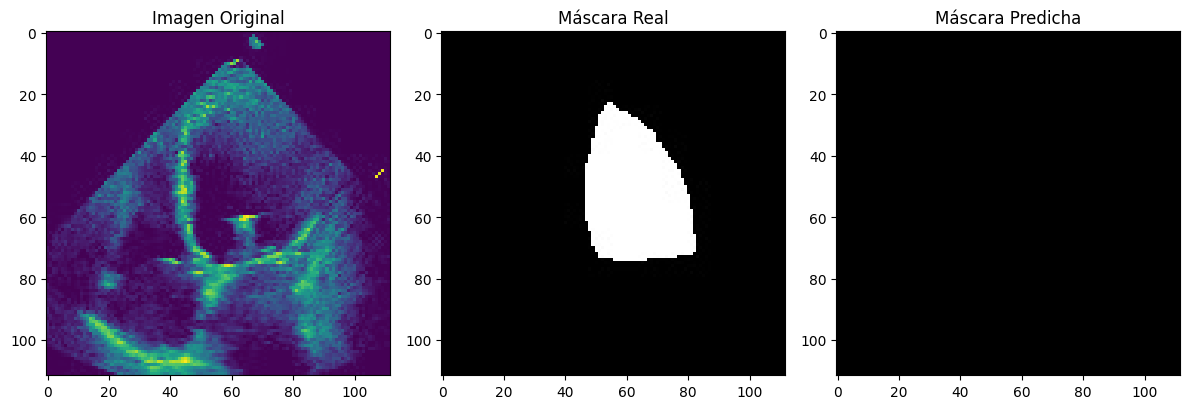

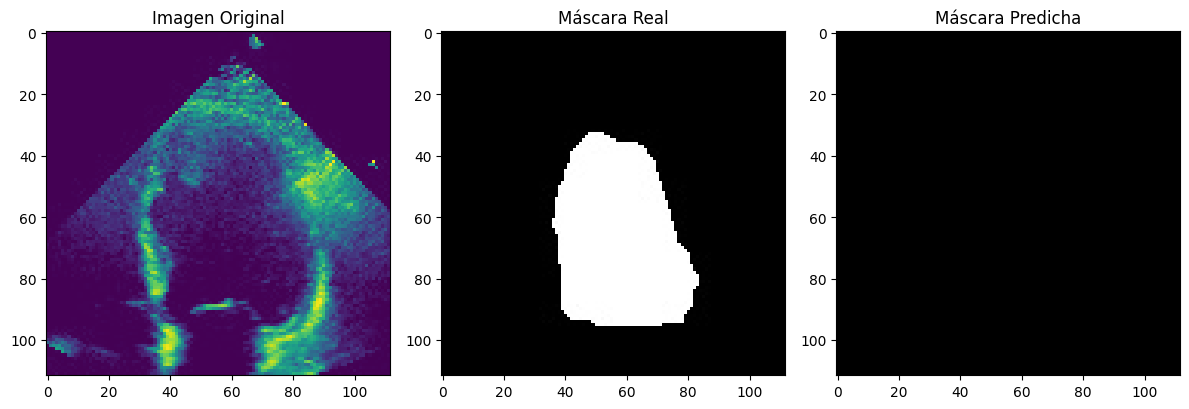

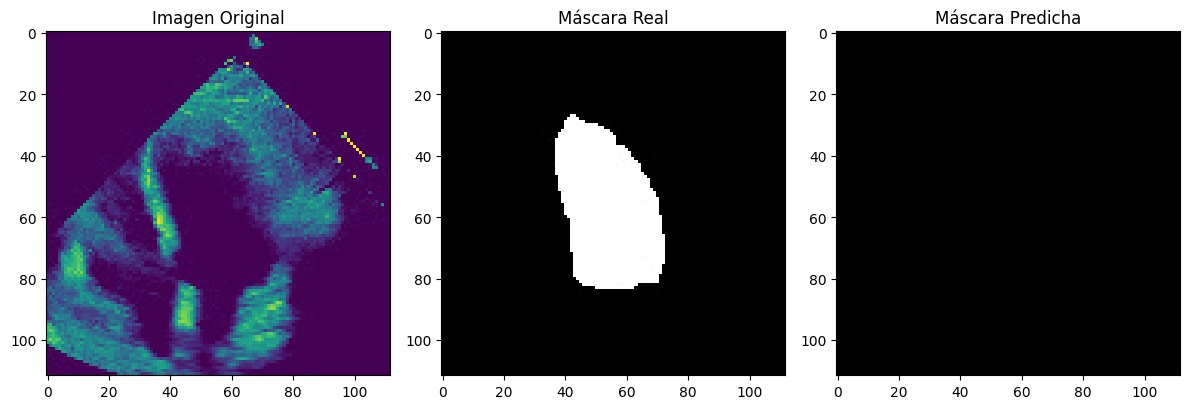

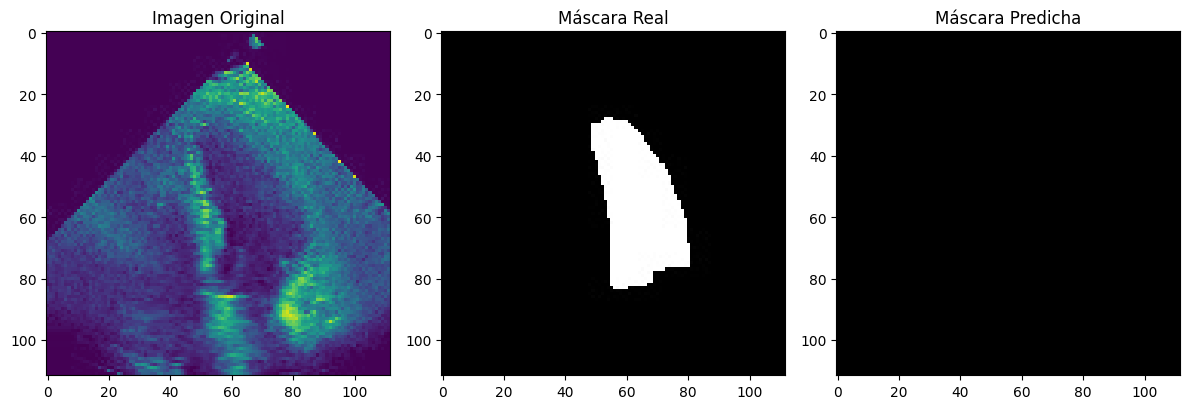

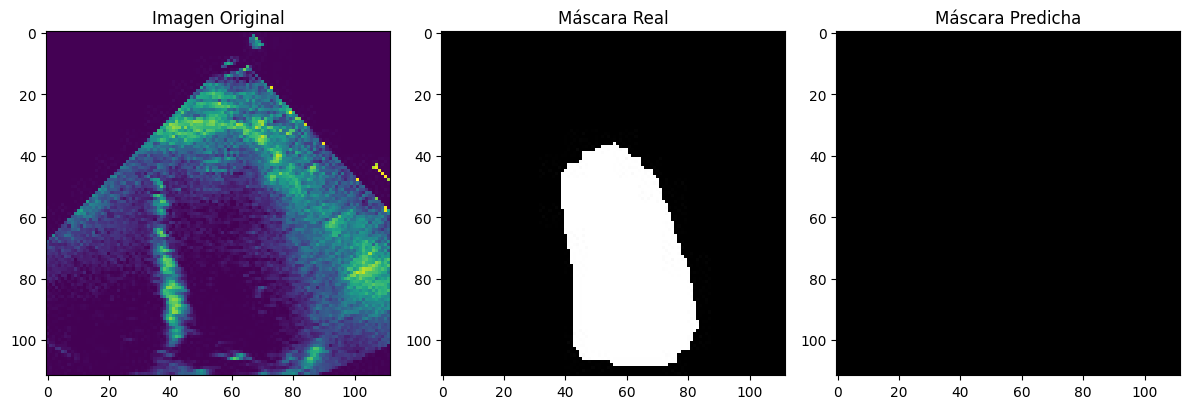

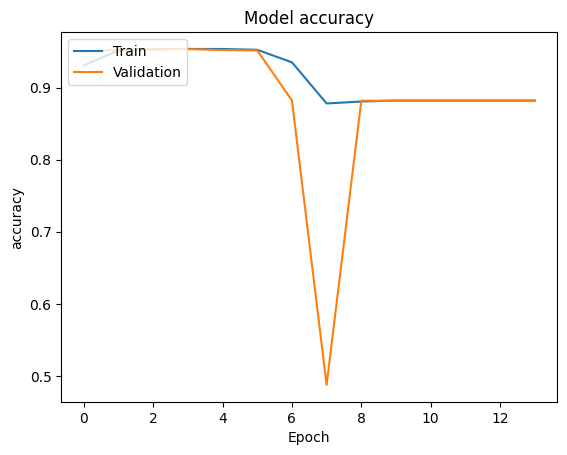

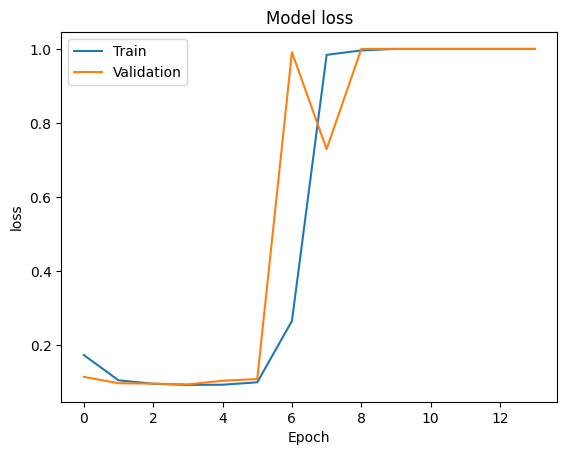

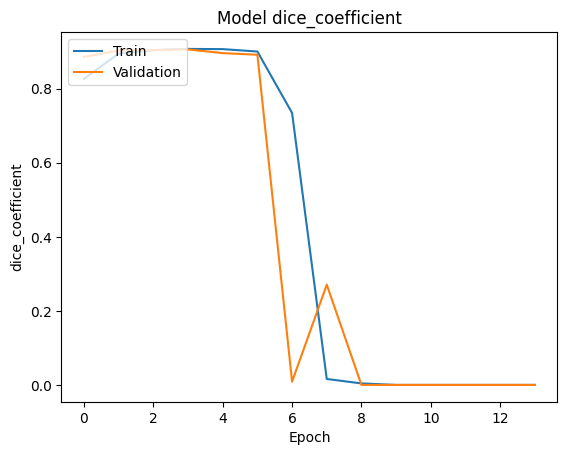

In [10]:
# Save model history information to a json file
import json
import time
import matplotlib.pyplot as plt

# Generate a folder name
name_folder = 'mascara_{}'.format(time.strftime("%Y%m%d-%H%M%S"))
path = '../../Pruebas/{}/'.format(name_folder)
os.mkdir(path)

# Save history to a json file
path_json = '{}history.json'.format(path)

with open(path_json, 'w') as fp:
    json.dump(history.history, fp)

# Save model
path_model = '{}model.h5'.format(path)
model.save(path_model)

# Save model summary to a txt file
path_summary = '{}summary.txt'.format(path)
with open(path_summary, 'w') as fp:
    model.summary(print_fn=lambda x: fp.write(x + '\n'))

# Save model metrics to a txt file
path_metrics = '{}metrics.txt'.format(path)
with open(path_metrics, 'w') as fp:
    fp.write('Test loss: {}\n'.format(evaluation[0]))
    fp.write('Test dice coefficient: {}\n'.format(evaluation[1]))
    fp.write('Test accuracy: {}\n'.format(evaluation[2]))
    fp.write('Model optimizer: {}\n'.format(model.optimizer.__class__.__name__))
    fp.write('Model activation: {}\n'.format(model.layers[-1].activation.__name__))
    fp.write('Model learning rate: {}\n'.format(model.optimizer.lr.numpy()))
    
# Generate a folder inside the folder of the model for the images
path_images = '{}images/'.format(path)
os.mkdir(path_images)

# Generate a folder inside the folder of the images for plot images
path_plot_images = '{}plot_images/'.format(path_images)
os.mkdir(path_plot_images)

# Generate a folder inside the folder of the images for prediction images
path_test_images = '{}predicitons/'.format(path_images)
os.mkdir(path_test_images)

# Save prediction images
# Función para visualizar una muestra de imágenes y sus máscaras de segmentación predichas
def visualize_segmentation(images, masks, predictions):
    num_samples = len(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 6))

        # Imagen original
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Imagen Original')

        # Máscara de segmentación real
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Máscara Real')

        # Máscara de segmentación predicha
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title('Máscara Predicha')

        plt.tight_layout()
        plt.savefig('{}{}.png'.format(path_test_images, i))

# Supongamos que tienes un conjunto de datos de prueba con imágenes y máscaras
# Puedes utilizar el modelo para obtener las máscaras predichas en el conjunto de prueba
predictions = model.predict(test_dataset)

# Elije algunas muestras aleatorias para visualizar
num_samples_to_visualize = 5
sample_indices = np.random.choice(len(test_images[:10]), num_samples_to_visualize, replace=False)

sample_images = [test_images[i] for i in sample_indices]
sample_masks = [test_masks[i] for i in sample_indices]
sample_predictions = [predictions[i] for i in sample_indices]

# Llama a la función para visualizar las imágenes y máscaras
visualize_segmentation(sample_images, sample_masks, sample_predictions)

# Save plot images
for i in ['accuracy', 'loss','dice_coefficient']:
    plt.figure()
    plt.plot(history.history[i])
    plt.plot(history.history['val_{}'.format(i)])
    plt.title('Model {}'.format(i))
    plt.ylabel(i)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('{}{}.png'.format(path_plot_images, i))

# 

In [11]:
# Commit and push to GitHub
import subprocess

# Add all files to git
subprocess.run(['git', 'add', '../../Pruebas/{}'.format(name_folder)])

# Commit to git
subprocess.run(['git', 'commit', '-m', 'Add new model: {}'.format(name_folder)])

# Push to GitHub
subprocess.run(['git', 'push'])

CompletedProcess(args=['git', 'push'], returncode=0)